<a href="https://colab.research.google.com/github/mohitagr18/multimodal_style_coach/blob/main/Style_Coach2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --upgrade google-adk

### The 5 Agents on the Team

1.  **Style Coach Agent (The Manager):** The user-facing agent that coordinates the entire team.
2.  **Input Analysis Agent (The Specialist):** An expert in understanding and deconstructing images.
3.  **Trend Research Agent (The Consultant):** Uses Google Search to understand abstract styles and current trends.
4.  **Mercari Search Agent (The Worker):** The retrieval expert that runs targeted searches on the product database.
5.  **Styling & Reasoning Agent (The Creative):** The fashion expert that assembles outfits and explains the style choices.

***



## Full Workflow Example

**Scenario:** A user uploads a photo of a vintage-looking brown leather jacket and asks the `Style Coach Agent`:

> **"I just thrifted this jacket. Can you help me style an outfit around it for a rock concert this fall?"**

---
#### Step 1: The Manager Receives the Request

The **`Style Coach Agent`** receives the combined input (image + text). It knows it can't handle this alone and begins to delegate.

---
#### Step 2: The Specialist Analyzes the Image

The `Style Coach Agent` first needs to understand the core item. It sends the uploaded image to the **`Input Analysis Agent`**.

* **Action:** The `Input Analysis Agent` processes the image using multimodal models.
* **Output:** It returns a structured description back to the manager:
    > `{ "item": "leather jacket", "style": "vintage, bomber", "color": "dark brown" }`

---
#### Step 3: The Consultant Researches the Vibe

Now the `Style Coach Agent` understands the jacket. Next, it needs to understand the *vibe* of a "rock concert this fall." It sends this query to the **`Trend Research Agent`**.

* **Action:** The `Trend Research Agent` uses the **Google Search tool** to find articles and images about current fall concert fashion and rock aesthetics.
* **Output:** It returns a concise summary back to the manager:
    > *"Fall concert style is currently blending 90s grunge with classic rock elements. Key complementary items include vintage band t-shirts, dark wash or black distressed denim, and chunky leather boots like Doc Martens."*

---
#### Step 4: The Worker Finds the Pieces

The `Style Coach Agent` now has a complete shopping list. It commands the **`Mercari Search Agent`** to find the necessary pieces in the product database.

* **Action:** The `Mercari Search Agent` performs several targeted vector searches based on the combined information:
    1.  A search for a visually similar **vintage band t-shirt**.
    2.  A search for **black distressed denim jeans** with text descriptions matching "90s" or "grunge."
    3.  A search for **chunky leather boots** visually similar to Doc Martens.
* **Output:** It returns a list of the top 3-5 matching items for each category.

---
#### Step 5: The Creative Assembles the Look

The `Style Coach Agent` takes the user's original jacket and the pool of items found by the worker and hands it all to the final expert, the **`Styling & Reasoning Agent`**.

* **Action:** This agent uses its advanced LLM capabilities to mix and match the items into a coherent outfit. It selects the best-fitting t-shirt, jeans, and boots to go with the jacket.
* **Output:** It generates a complete, styled look with a detailed explanation:
    > **Look 1: 90s Grunge Rock**
    > * **Your Jacket:** The brown leather jacket is the perfect centerpiece.
    > * **Top:** I've paired it with this faded Nirvana band t-shirt to lean into the 90s grunge theme.
    > * **Bottoms:** These black distressed jeans create a slim silhouette that contrasts well with the bulkier jacket.
    > * **Shoes:** To complete the look, these chunky platform boots give you an authentic rock concert feel and are comfortable enough for standing.

---
#### Step 6: The Manager Presents the Final Result

The `Style Coach Agent` receives the beautifully formatted output from the `Styling & Reasoning Agent` and presents it as the final, polished answer to the user. This completes the workflow.

## Environment Setup

In [1]:
# Import necessary libraries
import os
import logging
import asyncio
import json
from typing import List
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import  InMemorySessionService
from google.adk.tools.agent_tool import AgentTool
from google.adk.tools import google_search
from google.genai import types

# Ignore warnings from ADK and Gemini APIs
logging.getLogger("google.adk.runners").setLevel(logging.ERROR)
logging.getLogger("google_genai.types").setLevel(logging.ERROR)

In [2]:
from google.colab import userdata

# Retrieve the secret key from Colab's secrets manager
my_api_key = userdata.get('GOOGLE_API_KEY')

# Set the environment variable using the retrieved secret
os.environ["GOOGLE_API_KEY"] = my_api_key


# Set environment variables required for running ADK (with Gemini API Key)
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "False"



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


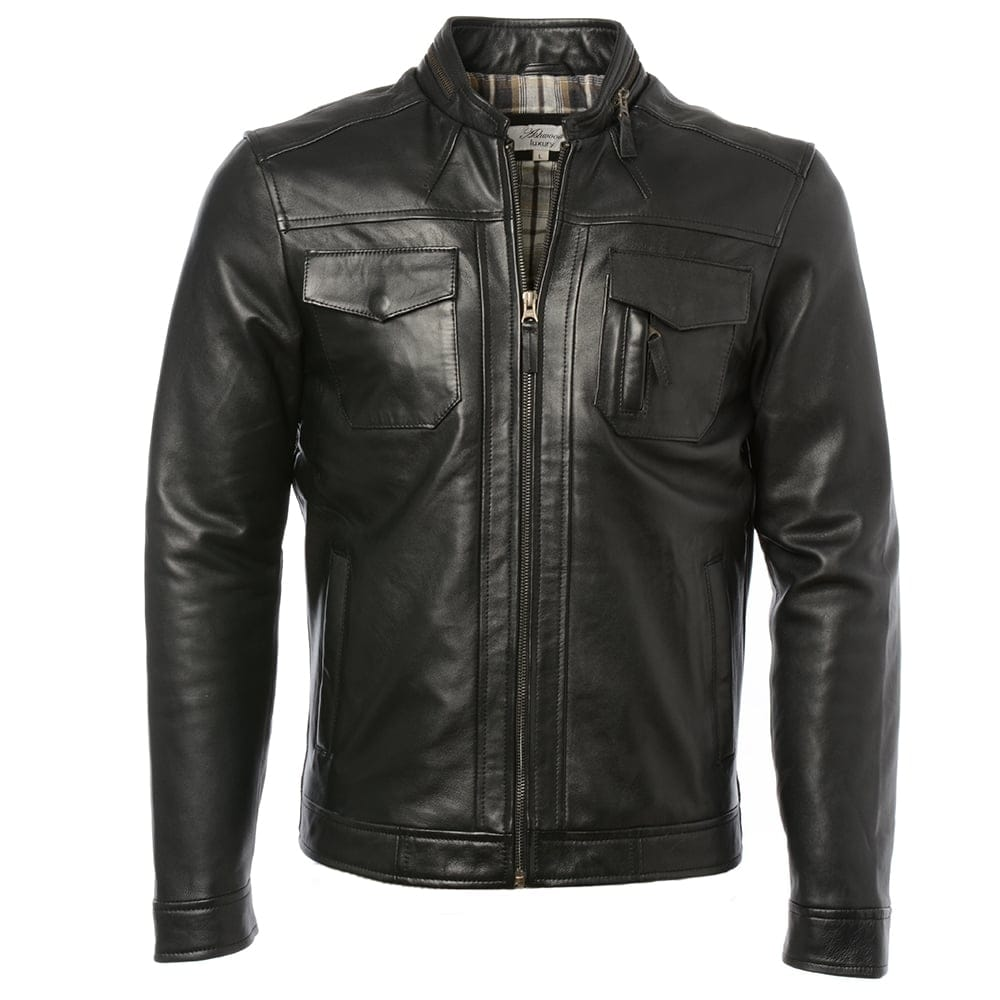

In [4]:
from IPython.display import Image, display

# Define the path to your image in Google Drive
image_path = '/content/drive/My Drive/Colab Notebooks/images/test_img1.jpg'

# Display the image
try:
    display(Image(filename=image_path))
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
except Exception as e:
    print(f"An error occurred: {e}")

## Create Testing Agent

For testing the agents we will build, we need to define a function test_agent that uses Runner and SessionService to emulate an agent runtime environment. To learn more about the agent runtime, see the Agent Runtime doc.

In [9]:
import pathlib

# Define the app_name and user_id for testing the agents
APP_NAME = "style_coach_app"
USER_ID = "user_1"
session_service = InMemorySessionService()

async def test_agent(
    agent,
    query: str | None = None,
    image_path: str | None = None,
):
    """Sends a text query and/or an image to the agent and prints the response."""

    if not query and not image_path:
        print("Error: Please provide a text query or an image path.")
        return

    # Build a list of parts for the user's message
    parts = []
    log_display = ""
    if query:
        parts.append(types.Part(text=query))
        log_display += f"Query: '{query}'"
    if image_path:
        img = pathlib.Path(image_path)
        if not img.exists():
            print(f"Error: Image file not found at {image_path}")
            return

        # Create an image part from the file path
        image_part = types.Part(
            inline_data=types.Blob(
                mime_type="image/jpeg",  # Or other appropriate mime type
                data=img.read_bytes(),
            )
        )
        parts.append(image_part)
        log_display += f" | Image: '{image_path}'"

    print(f"\n>>> User Input: {log_display.strip()}")

    # Create a session
    session = await session_service.create_session(
      app_name=APP_NAME,
      user_id=USER_ID,
    )

    # Create a Runner
    runner = Runner(
        app_name=APP_NAME,
        agent=agent,
        session_service=session_service,
    )

    # Prepare the user's message with all parts
    content = types.Content(role="user", parts=parts)

    final_response_text = None
    # We iterate through events from run_async to find the final answer.
    async for event in runner.run_async(
        user_id=USER_ID, session_id=session.id, new_message=content
    ):
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response_text = event.content.parts[0].text
            break
    # Find the final response text...
    final_response_text = None
    async for event in runner.run_async(
        user_id=USER_ID, session_id=session.id, new_message=content):
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response_text = event.content.parts[0].text
            break

    # --- NEW, STRUCTURED OUTPUT ---
    print("\n" + "="*50)
    print("✨ Your Styling Results ✨")
    print("="*50)

    print(f"\n**Your question:**\n> {log_display.strip()}")

    print(f"\n**Agent's response:**")
    if final_response_text:
        # Add a markdown blockquote '>' to each line for clean wrapping
        formatted_response = "\n".join(
            [f"> {line}" for line in final_response_text.split('\n')]
            )
        print(formatted_response)
    else:
        print("> The agent did not generate a response.")
    print("="*50)

| **Agent**                 | **Description**                                                                                                                                                                                          |
|---------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Style Coach Agent         | This is the main, user-facing agent that orchestrates the entire process and manages the conversation. Its role is identical to the original Shop Agent.                                                 |
| Trend Research Agent      | This agent's function is to use an external tool (Google Search) to gather real-world, up-to-date context to better understand a user's vague request.                                                   |
| Input Analysis Agent      | This is a specialized agent required for the Style Coach's advanced multimodal capabilities. Its sole job is to interpret and deconstruct image inputs, which was not a feature of the original example. |
| Mercari Search Agent      | This is a dedicated, more powerful agent responsible for crafting and executing sophisticated vector searches on the product database.                                                                   |
| Styling & Reasoning Agent | This agent adds a crucial reasoning layer that assembles those items into complete, styled outfits and explains why they work together, embodying the "coach" role.                                      |

## Shop Agent

In [10]:
def item_search_tool(query: str) -> str:
    """Searches a secondhand marketplace for clothing items based on a query.

    Args:
        query: A descriptive search query for a clothing item.
               Example: "vintage leather jacket"
    """
    print(f"DEBUG: item_search_tool was called with query: '{query}'")

    # This is our placeholder data, simulating a real database call.
    mock_items = {
        "items": [
            {
                "id": "123",
                "name": "Vintage Distressed Leather Jacket",
                "description": ("A perfect 90s-style leather jacket with a "
                                "worn-in feel. Great for a grunge or rockstar look."),
                "price": "85.00",
                "category": "Outerwear"
            },
            {
                "id": "456",
                "name": "Classic Plaid Mini Skirt",
                "description": ("A red and black plaid skirt. A staple for any "
                                "alternative or preppy wardrobe."),
                "price": "25.00",
                "category": "Skirts"
            }
        ]
    }
    return json.dumps(mock_items)

In [11]:
# Define the core instructions for the agent in a variable.
instruction = f'''
You are a shopper's concierge. Your goal is to help a user find clothes
by following these steps for any style-based or vague request:

1.  First, call the `TrendResearchAgent` with the user's query to get a
    list of exactly 5 specific search queries.

2.  Second, take the entire list of 5 queries you received and immediately
    pass it to the `item_search_tool` to find relevant items.

3.  Finally, present the items you found to the user in a friendly and
    helpful way with item's name, description and the image url.
'''

# Create the agent instance using the Agent class constructor.
style_coach_agent = Agent(
    model='gemini-2.5-flash',  # Using a modern Gemini model
    name='StyleCoachAgent',
    description=(
        'A conversational agent that acts as a personal stylist for secondhand fashion.'
    ),
    instruction=instruction,
    tools=[item_search_tool]  # Pass the tool function in a list.
)

In [12]:
await test_agent(agent=style_coach_agent,
        query="Can you find a vintage leather jacket for me?")


>>> User Input: Query: 'Can you find a vintage leather jacket for me?'
DEBUG: item_search_tool was called with query: 'vintage leather jacket'
DEBUG: item_search_tool was called with query: 'vintage leather jacket'

✨ Your Styling Results ✨

**Your question:**
> Query: 'Can you find a vintage leather jacket for me?'

**Agent's response:**
> Here is a vintage leather jacket I found for you:
> 
> **Vintage Distressed Leather Jacket**
> A perfect 90s-style leather jacket with a worn-in feel. Great for a grunge or rockstar look.


## Trend Research Agent

This is a specialized agent whose only job is to understand current fashion trends. When a user asks a broad or style-focused question like, "What's in style for this fall?" or "Help me find a 'cottagecore' outfit," our main agent isn't equipped to answer that directly.

Instead, the `StyleCoachAgent` will delegate that task to the `TrendResearchAgent`. This new agent will use **Google Search** to find relevant articles, blog posts, and images to understand the trend. It will then pass a summary or a list of key clothing items back to the main agent.

This multi-agent approach makes our system much smarter and more scalable. Each agent has one job and does it well. 🤖

In [13]:
# 1. Define the instructions for the new agent.
# These are very specific to its single task: research.
research_instruction = f'''
You are a fashion market researcher. Your goal is to understand a
user's style query and produce a JSON object with two things: a brief
summary of the style, and a list of 5 specific search queries.

Your output MUST be a single, valid JSON object with two keys:
1.  "summary": A one or two-sentence summary of the style.
2.  "queries": A list of 5 specific, actionable search query strings.

Example user query: "What is cottagecore style?"
Your expected output:
{{
    "summary": "Cottagecore is a romanticized aesthetic of rural life, focusing on natural fabrics, floral prints, and comfortable, flowing silhouettes.",
    "queries": [
        "flowy floral midi dress",
        "puff sleeve blouse",
        "knit cardigan",
        "tiered linen skirt",
        "simple leather sandals"
    ]
}}
'''

# 2. Create the TrendResearchAgent instance.
trend_research_agent = Agent(
    model='gemini-2.5-flash',
    name='TrendResearchAgent',
    description=(
        'Researches fashion trends using Google Search to understand styles, '
        'aesthetics, and key clothing items.'
    ),
    instruction=research_instruction,
    tools=[google_search] # Give the agent access to the Google Search tool.
)

print("✅ TrendResearchAgent has been defined.")
print(f"   - Name: {trend_research_agent.name}")
print(f"   - Tools: {[tool.name for tool in trend_research_agent.tools]}")

✅ TrendResearchAgent has been defined.
   - Name: TrendResearchAgent
   - Tools: ['google_search']


### The `AgentTool` Wrapper 🔧
To use one agent as a tool for another, you can't just pass the agent object directly. You must wrap it in the `AgentTool` class. This wrapper officially adapts the agent so that it can be correctly interpreted and called from within another agent's toolset.



In [14]:
style_coach_agent = Agent(
    model='gemini-2.5-flash',
    name='StyleCoachAgent',
    description=(
        'A conversational agent that acts as a personal stylist for secondhand fashion.'
    ),
    instruction=instruction,
    tools=[
        item_search_tool,
        AgentTool(agent=trend_research_agent)  # <-- Correctly wrapped in AgentTool
    ]
)

print("✅ style_coach_agent has been correctly updated.")
# print(f"   - New Tools: {[tool.name for tool in style_coach_agent.tools]}")

✅ style_coach_agent has been correctly updated.


In [15]:
await test_agent(agent=style_coach_agent,
        query="What is the 'cottagecore' aesthetic?")


>>> User Input: Query: 'What is the 'cottagecore' aesthetic?'
DEBUG: item_search_tool was called with query: 'flowy floral midi dress puff sleeves, linen peasant blouse embroidered, tiered gingham maxi skirt, oversized knit cardigan natural fibers, pinafore dress cotton linen'
DEBUG: item_search_tool was called with query: 'flowy floral maxi dress, puff sleeve linen blouse, knit cardigan natural fibers, tiered midi skirt with ruffles, prairie style sundress'

✨ Your Styling Results ✨

**Your question:**
> Query: 'What is the 'cottagecore' aesthetic?'

**Agent's response:**
> I apologize, it seems like the search tool is still returning items that don't quite fit the 'cottagecore' aesthetic. I'm having trouble finding relevant items with the current search capabilities.
> 
> The items I found are:
> 
> **Vintage Distressed Leather Jacket**
> A perfect 90s-style leather jacket with a worn-in feel. Great for a grunge or rockstar look.
> 
> **Classic Plaid Mini Skirt**
> A red and black p

In [ ]:
await test_agent(agent=style_coach_agent,
        query="What jacket should I wear with a Kurta for a diwali function?")

## Step 1: The Low-Level `call_vector_search` Utility

With the basic agent above, we would like to add an item search capability. To achieve this, here we define a function call_query_api that sends an HTTP request to a REST endpoint provided by the Vector Search Interactive demo. For the detail of each parameter sent to the endpoint, refer to the demo page.

In [16]:
import requests
import json

def call_vector_search(url: str, query: str, rows: int = 3) -> dict | None:
    """
    Calls a custom Vector Search backend API for querying.

    Args:
        url: The URL of the search endpoint.
        query: The query string.
        rows: The number of result rows to return.

    Returns:
        A dictionary from the API's JSON response, or None on error.
    """
    headers = {'Content-Type': 'application/json'}
    # This payload is specific to the custom API endpoint in the tutorial.
    payload = {
        "query": query,
        "rows": rows,
        "dataset_id": "mercari3m_mm",
        "use_dense": True,
        "use_sparse": True,
        "rrf_alpha": 0.5,
        "use_rerank": True,
    }

    try:
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        response.raise_for_status()  # Raise an exception for bad status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error calling the search API: {e}")
        return None

In [17]:

# This is the specific API endpoint used in the tutorial.
SEARCH_API_URL = "https://www.ac0.cloudadvocacyorg.joonix.net/api/query"

def item_search_tool(queries: List[str]) -> str:
    """
    Finds fashion items by running a list of search queries against the
    secondhand marketplace vector database.

    Args:
        queries: A list of descriptive search queries to run.
                 Example: ["crochet top", "wide-leg denim pants"]
    """
    items = []
    for query in queries:
        result = call_vector_search(
            url=SEARCH_API_URL,
            query=query,
            rows=3,  # Find 3 items per query
        )
        if result and "items" in result:
            items.extend(result["items"])

    print("-----")
    print(f"User queries: {queries}")
    print(f"Found: {len(items)} items")
    print("-----")

    # Return the final list of found items as a JSON string.
    return json.dumps({"items": items})

In [18]:
# Define the core instructions for the agent in a variable.
instruction = f'''
You are a shopper's concierge. Your goal is to help a user find clothes
by following these steps:

1.  First, call the `TrendResearchAgent` to get a JSON object that
    contains a "summary" and a list of "queries".

2.  Second, take ONLY the "queries" list from that JSON object and pass
    it to the `item_search_tool`.

3.  Finally, formulate a response to the user. Start your response with
    the "summary" you received in Step 1. Then, present the items
    you found in Step 2.
'''

# Create the agent instance using the Agent class constructor.
style_coach_agent = Agent(
    model='gemini-2.5-flash',  # Using a modern Gemini model
    name='StyleCoachAgent',
    description=(
        'A conversational agent that acts as a personal stylist for secondhand fashion.'
    ),
    instruction=instruction,
    tools=[item_search_tool]  # Pass the tool function in a list.
)

In [19]:
await test_agent(
        agent=style_coach_agent,
        query="What are the key items for a 'cottagecore' aesthetic?"
    )


>>> User Input: Query: 'What are the key items for a 'cottagecore' aesthetic?'
-----
User queries: ['floral print dresses', 'puff sleeve blouses', 'smock dresses', 'gingham skirts', 'embroidered cardigans', 'basket bags', 'mary jane shoes']
Found: 21 items
-----

✨ Your Styling Results ✨

**Your question:**
> Query: 'What are the key items for a 'cottagecore' aesthetic?'

**Agent's response:**
> Cottagecore is an aesthetic inspired by a romanticized interpretation of Western agricultural life. It centers on ideas of simple living, harmony with nature, and traditional skills. Key fashion elements often include floral prints, natural fabrics, and silhouettes that evoke a rustic, whimsical feel.
> 
> Here are some items I found that fit the cottagecore aesthetic:
> 
> *   **Floral Print Dresses**:
>     *   "floral dresses" - New brand condition size M - [https://www.mercari.com/us/item/m89177291784](https://www.mercari.com/us/item/m89177291784)
>     *   "NEW Veronica Beard Corsica Silk

In [ ]:
await test_agent(
        agent=style_coach_agent,
        query="What should I wear for a 90s rock star music fest?"
    )

## Adding Multimodal Capability

Now that our agent can handle complex text queries, the next logical step is to add **multimodal capabilities** by building the `InputAnalysisAgent`.

***
### Why This is the Next Step 📸

Fashion is inherently visual. Users often start with an image—a photo of an outfit they saw, a screenshot from social media, or a picture of an item they already own. By enabling our agent to understand images, we make it dramatically more powerful and intuitive.

This will unlock brand-new ways for users to interact with our Style Coach, such as:
* "What kind of shoes would go with this dress I own?" (user uploads a photo of their dress)
* "Help me find a budget-friendly version of this influencer's outfit." (user uploads a screenshot)



***
### The Plan

We'll follow a familiar pattern: build a new specialist agent and then teach our main agent how to delegate tasks to it.

1.  **Define the `InputAnalysisAgent`:** This will be a new, highly specialized agent. Its only job is to receive an image and, using its multimodal model (like `gemini-1.5-flash`), return a structured text description (a JSON object) of the key item in the image, including its type, style, and color.

2.  **Update the `StyleCoachAgent`:** We will upgrade our main agent to handle image inputs. This involves two changes:
    * **Adding the New Tool:** We'll add the `InputAnalysisAgent` (wrapped in an `AgentTool`) to the `style_coach_agent`'s list of tools.
    * **Updating the Instructions:** We'll add a new rule to its prompt, telling it: "If the user's input contains an image, your very first step MUST be to call the `InputAnalysisAgent` to identify the item in the photo."

This will create a new workflow where, for any multimodal query, the `style_coach_agent` will first get a detailed description of the image before proceeding with research or item searching.



### How Text and Image Queries are Combined

The text and image information are combined within the reasoning process of the main **`style_coach_agent`**. It doesn't just smash the text together; it synthesizes the information to form a complete picture of the user's goal.

Think of it like a detective building a case file. 🕵️

**Scenario:** The user uploads a photo of a silver necklace and asks, **"What top should I wear with this for a formal event?"**

Here is the step-by-step workflow:

1.  **Receiving the Evidence:** The `style_coach_agent` receives two pieces of evidence: the user's **text** and the **image**.

2.  **Calling the Specialist:** Its instructions state that if there's an image, it MUST call the `InputAnalysisAgent` first. It sends the image to this specialist.

3.  **Getting the Lab Report:** The `InputAnalysisAgent` returns its analysis as a structured JSON object:

    > `{ "item": "silver necklace", "style": "dainty, minimalist", "color": "silver" }`

4.  **Synthesizing the Case File:** The `style_coach_agent`'s underlying LLM now has a complete "dossier" on the user's request. It internally combines the information into a complete goal:

    > "The user needs to find a **top** that would look good with a **dainty, minimalist, silver necklace** for a **formal event**."

5.  **Taking Action:** With this complete understanding, it can now make an intelligent decision. It recognizes "formal event" as a contextual query, so it will call the `TrendResearchAgent` with a very specific prompt like, "Tops to wear with minimalist silver jewelry for formal events." The research results will then be used to call the `item_search_tool` for specific items like a "black silk camisole" or a "satin high-neck blouse."

### Step 1 - Define the `InputAnalysisAgent`

This is a new, highly focused agent. It has no tools of its own; its sole purpose is to use its powerful multimodal model (gemini-2.5-flash) to analyze an image and return a structured JSON description.

In [20]:
# Define the instructions for the image analysis agent.
analysis_instruction = f'''
You are a specialist AI model that analyzes images of fashion items. Your
only job is to identify the primary item in an image and return a
structured JSON object describing it.

- Your output MUST be only a single, valid JSON object.
- Do not add any conversational text or preambles.

The JSON object should contain the following keys:
- "item": The type of item (e.g., "leather jacket", "silver necklace", "ankle boots").
- "style": Descriptive keywords (e.g., "vintage", "minimalist", "chunky").
- "color": The primary color of the item.

Example Output:
{{
    "item": "leather jacket",
    "style": "vintage, bomber",
    "color": "dark brown"
}}
'''

# Create the agent instance. It has no tools.
input_analysis_agent = Agent(
    model='gemini-2.5-flash',
    name='InputAnalysisAgent',
    description=(
        'Analyzes an image of a clothing item and returns a structured JSON'
        ' description of its type, style, and color.'
    ),
    instruction=analysis_instruction,
    tools=[] # This agent is a specialist and needs no external tools.
)

print("✅ InputAnalysisAgent has been defined.")

✅ InputAnalysisAgent has been defined.


### Step 2: Update the `StyleCoachAgent` to Use It
Now, we'll upgrade our main agent. We'll add the new InputAnalysisAgent to its toolset and, most importantly, update its instructions to include a new rule for handling image inputs.

In [21]:
# Update the main agent's instructions with a new rule for images.
main_instruction = f'''
You are an expert style coach. Your goal is to help users find clothes.
You MUST follow a strict reasoning process based on the user's input.

**Image Input Rule (HIGHEST PRIORITY):**
If the user provides an image, your FIRST step, before anything else, is to
call the `InputAnalysisAgent` to get a JSON description of the item.
Then, use that description to inform the rest of your plan.

**Style-Based Query Plan:**
For queries mentioning a style, aesthetic, or event (e.g., 'cottagecore'):
1.  Call the `TrendResearchAgent` to get a JSON object with a 'summary'
    and a list of 'queries'.
2.  Use ONLY the 'queries' list to call the `item_search_tool`.
3.  Formulate a final response using the 'summary' for context and the
    items you found.

**Simple Query Plan:**
For simple item requests (e.g., 'find a black leather jacket'), you can
call the `item_search_tool` directly.

**Final Response Generation:**
Your final response to the user should be a friendly, conversational paragraph.
First, use the 'summary' from your research (if you have one) to provide
context and styling advice. Then, introduce the specific items you found.

For each item you mention, present it by showing its **'name'**, **'description'** followed by its
**'image_url'**. Do not use the regular item 'url' field.
'''

# Update the agent's definition to include the new tool.
style_coach_agent = Agent(
    model='gemini-2.5-flash',
    name='StyleCoachAgent',
    description='A conversational agent for secondhand fashion.',
    instruction=main_instruction,
    tools=[
        item_search_tool,
        AgentTool(agent=trend_research_agent),
        AgentTool(agent=input_analysis_agent) # <-- Add the new agent here
    ]
)

print("✅ style_coach_agent has been updated with multimodal capabilities.")

✅ style_coach_agent has been updated with multimodal capabilities.


In [22]:
await test_agent(
    agent=style_coach_agent,
    query="What should I wear with this scarf for a party?",
    image_path="/content/drive/MyDrive/Colab Notebooks/images/test_img2.jpeg"
)


>>> User Input: Query: 'What should I wear with this scarf for a party?' | Image: '/content/drive/MyDrive/Colab Notebooks/images/test_img2.jpeg'
-----
User queries: ['black party dress', 'cream sweater dress', 'dark green slip dress']
Found: 9 items
-----
-----
User queries: ['gold party dress', 'emerald green velvet dress', 'black satin jumpsuit']
Found: 8 items
-----

✨ Your Styling Results ✨

**Your question:**
> Query: 'What should I wear with this scarf for a party?' | Image: '/content/drive/MyDrive/Colab Notebooks/images/test_img2.jpeg'

**Agent's response:**
> For a party, you can make your beautiful chunky knit terracotta scarf a statement piece by pairing it with contrasting textures and colors. The warmth of the terracotta will pop against richer, deeper tones or sparkling metallics.
> 
> Here are some fantastic options to wear with your scarf for a party:
> 
> **Black and Gold Party Dress**
> description: Black and Gold Party Dress. Stretchy Cotton. Size XL
> image_url: htt

In [ ]:
await test_agent(
    agent=style_coach_agent,
    query="What should I wear with this watch for a party?",
    image_path="/content/drive/MyDrive/Colab Notebooks/images/test_img4.webp"
)

In [ ]:
await test_agent(
    agent=style_coach_agent,
    query="",
    image_path="/content/drive/MyDrive/Colab Notebooks/images/test_img3.jpg"
)


## What's Next: Adding a Creative Stylist

To elevate our agent from a smart shopper to a true stylist, we'll introduce a **`Styling & Reasoning Agent`**. This creative specialist will act as the team's "creative director." Its job is to take a list of found items—like tops, pants, and shoes—and intelligently assemble them into 1-3 complete, curated outfits, making the final output far more useful.


In [33]:
# Step 1: Create the Styling & Reasoning Agent (The Creative)
styling_instruction = '''
You are a creative fashion expert and styling specialist. Your job is to take
structured fashion data and create complete, curated outfits with detailed
explanations.

**Input Format Expected:**
You will receive a JSON object with this EXACT structure:
{
    "user_query": "original user request",
    "image_analysis": {...} or null,
    "style_context": "trend research summary",
    "available_items": [
        {
            "id": "item_id",
            "name": "item_name",
            "description": "item_description",
            "price": "item_price",
            "category": "item_category",
            "image_url": "item_image_url"
        }
    ]
}

**Your Task:**
1. Analyze the user's needs based on their query and any image analysis
2. Use the style context to understand the aesthetic direction
3. From the available_items, curate 2-3 complete outfit combinations
4. Provide detailed styling explanations for each outfit

**Output Format:**
Present your response as natural text (not JSON). For each outfit:

1. Start with a brief styling summary
2. Present each outfit with:
   - **Outfit Name**: Descriptive title
   - **Items**: For each item, show: **Name** (id), **Description**, **Image**: [image_url]
   - **Styling Rationale**: Detailed explanation of why this combination works
3. End with general styling tips

**CRITICAL**: Always include the image_url for every item using this exact format:
**Image**: [actual_image_url_here]

Example format:
**Classic Grunge Look**
* **Band T-Shirt** (id: m123): Vintage Nirvana tee with authentic wear
  **Image**: [https://example.com/image.jpg]
* **Distressed Jeans** (id: m456): High-waisted with strategic rips
  **Image**: [https://example.com/jeans.jpg]

IMPORTANT:
- Only use items from the provided available_items list
- Do not call any other agents or tools
- Focus on creating cohesive, wearable outfits
- Explain your fashion choices clearly
'''

styling_reasoning_agent = Agent(
    model='gemini-2.5-flash',
    name='StylingReasoningAgent',
    description=(
        'A creative fashion expert that assembles complete outfits from '
        'available items and provides detailed styling explanations.'
    ),
    instruction=styling_instruction,
    tools=[]  # This agent should not call other tools
)

print("✅ StylingReasoningAgent has been created.")


✅ StylingReasoningAgent has been created.


In [34]:
# Step 2: Update the StyleCoachAgent with optimized workflow logic and EXACT format matching
updated_main_instruction = '''
You are a style coach coordinator. Analyze the user's request type and choose
the most efficient workflow path.

**REQUEST TYPE CLASSIFICATION:**

**Type A - Direct Item Requests:**
- Simple queries like "find black boots", "show me leather jackets"
- Image-only uploads (no text query)
- Skip trend research, go directly to item search

**Type B - Style/Context Requests:**
- Queries mentioning styles, aesthetics, events, occasions
- Examples: "cottagecore outfit", "rock concert look", "formal dinner attire"
- Requires trend research for context

**Type C - Styling Help Requests:**
- Text + image combinations asking for styling advice
- Examples: "what goes with this jacket?", "complete this outfit"
- Needs image analysis + targeted search

**WORKFLOW PATHS:**

**Path A (Direct Requests):**
1. If image provided → call InputAnalysisAgent
2. Create targeted search queries based on image analysis or direct request
3. Call item_search_tool with specific queries
4. Pass results to StylingReasoningAgent for curation
5. Present final recommendations

**Path B (Style Research Needed):**
1. If image provided → call InputAnalysisAgent
2. Call TrendResearchAgent for style context and search queries
3. Call item_search_tool with queries from research
4. Pass all data to StylingReasoningAgent
5. Present final recommendations

**Path C (Combination Requests):**
1. Call InputAnalysisAgent for image analysis
2. Based on user query, decide if trend research is needed
3. Call item_search_tool with appropriate queries
4. Pass structured data to StylingReasoningAgent
5. Present final recommendations

**CRITICAL: Data Format for StylingReasoningAgent**
You MUST pass this EXACT JSON structure with EXACT field names:
{
    "user_query": "original user request",
    "image_analysis": {image analysis object or null},
    "style_context": "context from research or your interpretation",
    "available_items": [
        {
            "id": "item_id",
            "name": "item_name",
            "description": "item_description",
            "price": "item_price",
            "category": "item_category",
            "image_url": "use image_url field from search results NOT url field"
        }
    ]
}

**CRITICAL IMAGE URL HANDLING:**
- When processing items from item_search_tool, always use the "image_url" field
- NEVER use "url" field - use "image_url" field only
- If an item has no "image_url" field, set it to null
- Example transformation:
  From search: {"url": "broken_link", "image_url": "working_link"}
  Send to styling agent: {"image_url": "working_link"}

**EFFICIENCY RULES:**
- Don't call TrendResearchAgent for simple item searches
- Don't over-research obvious requests
- Always end with StylingReasoningAgent for consistent formatting
- Each specialist agent should only be called once per request
- Ensure exact JSON format matching between agents
'''

# Create the updated StyleCoachAgent
updated_style_coach_agent = Agent(
    model='gemini-2.5-flash',
    name='StyleCoachAgent',
    description='Coordinates the styling team and manages the overall workflow.',
    instruction=updated_main_instruction,
    tools=[
        item_search_tool,
        AgentTool(agent=trend_research_agent),
        AgentTool(agent=input_analysis_agent),
        AgentTool(agent=styling_reasoning_agent)  # Add the new agent
    ]
)

print("✅ StyleCoachAgent has been updated with proper workflow management.")


✅ StyleCoachAgent has been updated with proper workflow management.


In [35]:
# Step 3: Update the test_agent function to generate improved markdown reports
import pathlib
from datetime import datetime

async def test_agent_with_report(
    agent,
    query: str | None = None,
    image_path: str | None = None,
):
    """Sends a text query and/or an image to the agent and generates a styled report."""

    if not query and not image_path:
        print("Error: Please provide a text query or an image path.")
        return

    # Build a list of parts for the user's message
    parts = []
    log_display = ""
    if query:
        parts.append(types.Part(text=query))
        log_display += f"Query: '{query}'"
    if image_path:
        img = pathlib.Path(image_path)
        if not img.exists():
            print(f"Error: Image file not found at {image_path}")
            return

        # Create an image part from the file path
        image_part = types.Part(
            inline_data=types.Blob(
                mime_type="image/jpeg",
                data=img.read_bytes(),
            )
        )
        parts.append(image_part)
        log_display += f" | Image: '{image_path}'"

    print(f"\n>>> User Input: {log_display.strip()}")

    # Create a session
    session = await session_service.create_session(
      app_name=APP_NAME,
      user_id=USER_ID,
    )

    # Create a Runner
    runner = Runner(
        app_name=APP_NAME,
        agent=agent,
        session_service=session_service,
    )

    # Prepare the user's message with all parts
    content = types.Content(role="user", parts=parts)

    final_response_text = None
    # We iterate through events from run_async to find the final answer.
    async for event in runner.run_async(
        user_id=USER_ID, session_id=session.id, new_message=content
    ):
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response_text = event.content.parts[0].text
            break

    # Generate improved markdown report
    print("\n" + "="*70)
    print("🎨 PERSONAL STYLING REPORT")
    print("="*70)
    print()

    print("## 📝 Your Request")
    print(f"{log_display.strip()}")
    print()

    print("## ✨ Styling Recommendations")
    if final_response_text:
        # Clean and format the response with better spacing
        lines = final_response_text.split('\n')
        formatted_lines = []

        for i, line in enumerate(lines):
            stripped_line = line.strip()
            if not stripped_line:
                continue

            # Add proper spacing around sections
            if stripped_line.startswith('**') and stripped_line.endswith('**') and len(stripped_line) > 4:
                # This is likely a section header
                if formatted_lines:  # Add space before new sections (except first)
                    formatted_lines.append("")
                formatted_lines.append(f"### {stripped_line.strip('*')}")
                formatted_lines.append("")
            elif stripped_line.startswith('*'):
                # This is a bullet point
                formatted_lines.append(stripped_line)
            elif 'Image]:' in stripped_line:
                # This is an image URL line - format it better
                formatted_lines.append(f"  {stripped_line}")
            else:
                # Regular text
                formatted_lines.append(stripped_line)

        formatted_response = '\n'.join(formatted_lines)
        print(formatted_response)
    else:
        print("No styling recommendations were generated.")

    print()
    print("## 📊 Report Details")
    current_time = datetime.now()
    print(f"**Generated:** {current_time.strftime('%B %d, %Y at %I:%M %p')}")
    print(f"**Agent:** Multi-Agent Style Coach")
    print()
    print("="*70)

# Step 4: Create a simple test function that uses the original format for compatibility
async def test_enhanced_agent(
    query: str | None = None,
    image_path: str | None = None,
):
    """Test the enhanced multi-agent system with better formatting."""
    await test_agent_with_report(
        agent=updated_style_coach_agent,
        query=query,
        image_path=image_path
    )

In [36]:
await test_enhanced_agent(query="What should I wear for a 90s rock concert?")


>>> User Input: Query: 'What should I wear for a 90s rock concert?'
-----
User queries: ['oversized vintage band t-shirt', 'distressed high-waisted straight-leg jeans', 'plaid flannel shirt', 'black chunky combat boots', 'faux leather moto jacket']
Found: 15 items
-----

🎨 PERSONAL STYLING REPORT

## 📝 Your Request
Query: 'What should I wear for a 90s rock concert?'

## ✨ Styling Recommendations
Get ready to channel your inner rock star for the 90s concert! The key to nailing this aesthetic is all about effortless cool, rebellious vibes, and comfortable, lived-in pieces. Think grunge, band tees, distressed denim, and sturdy footwear. Here are a few curated outfits to get you into the spirit of the decade.
---
### **Outfit 1: The Iconic Grunge Rocker**
This outfit embraces the quintessential 90s grunge look, perfect for a concert. It's relaxed, cool, and pays homage to a true legend.
*   **Kurt Cobain shirt** (id: m66302694307): Over size, One size, Never worn, No tags, Unisex
**Image*

In [32]:
test_enhanced_agent(query="What should I wear for a 80s rock concert?")

<coroutine object test_enhanced_agent at 0x7d5d8e63aea0>

In [ ]:
print('await test_enhanced_agent(query="What should I wear for a rock concert?")')
print('await test_enhanced_agent(query="Style this item", image_path="path/to/image.jpg")')